In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [3]:
print (final.shape)
final.head(5)

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


Now  taking 50k +ve and 50k -ve reviews and concating them based on time :

In [4]:
# positive_reviews = final[final["Score"] == 1].sample(50000)
# print (positive_reviews.shape)


# negative_reviews = final[final["Score"] == 0].sample(50000)
# print (negative_reviews.shape)

# reviews_100k = pd.concat([positive_reviews,negative_reviews])
# print (reviews_100k.shape)
# reviews_100k = final.head(100000)

# reviews_100k["Time"] = pd.to_datetime(reviews_100k["Time"] , unit = "s")
# reviews_100k.head(5)


final["Time"] = pd.to_datetime(final["Time"] , unit = "s")
reviews_timesorted = final.sort_values(by = "Time")
print (reviews_timesorted.shape)
reviews_timesorted_score = reviews_timesorted["Score"]
print (reviews_timesorted_score.shape)
reviews_timesorted.head(5)

(364171, 12)
(364171,)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [5]:
# #Time-Based Sorting 
# reviews_100k = reviews_100k.sort_values(by="Time")
# reviews_100k_score = reviews_100k["Score"]
# print (reviews_100k_score.shape)
# reviews_100k.head(5)

reviews_100k = reviews_timesorted.head(100000)
print (reviews_100k.shape)


reviews_100k_score = reviews_100k["Score"]
print (reviews_100k_score.shape)

reviews_100k.head()

(100000, 12)
(100000,)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [6]:
pos_reviews = reviews_100k[reviews_100k["Score"] == 1]
print ("No of +ve reviews" , len(pos_reviews))
neg_reviews = reviews_100k[reviews_100k["Score"] == 0]
print ("No of -ve reviews" , len(neg_reviews))


No of +ve reviews 87729
No of -ve reviews 12271


In [7]:
from sklearn import model_selection

reviews_train, reviews_test, reviews_score_train , reviews_score_test = model_selection.train_test_split(reviews_100k, reviews_100k_score, test_size=0.3, random_state=0)
print (reviews_train.shape)
print (reviews_score_train.shape)
print (reviews_test.shape)
print (reviews_score_test.shape)

(70000, 12)
(70000,)
(30000, 12)
(30000,)


In [8]:
reviews_train, reviews_cv, reviews_score_train, reviews_score_cv = model_selection.train_test_split(reviews_train, reviews_score_train, test_size=0.3, random_state=0)
print (reviews_train.shape)
print (reviews_score_train.shape)
print (reviews_cv.shape)
print (reviews_score_cv.shape)

(49000, 12)
(49000,)
(21000, 12)
(21000,)


# Bag Of Words

In [9]:
count_vect = CountVectorizer() #in scikit-learn
reviews_train_bow = count_vect.fit_transform(reviews_train['CleanedText'].values)
reviews_cv_bow = count_vect.transform(reviews_cv['CleanedText'].values)
reviews_test_bow = count_vect.transform(reviews_test['CleanedText'].values)

print("the type of count vectorizer ",type(reviews_train_bow))
print (reviews_train_bow.shape)
print (reviews_cv_bow.shape)
print (reviews_test_bow.shape)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(49000, 26884)
(21000, 26884)
(30000, 26884)


In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score

alpha_values = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]


# empty list that will hold cv scores
# cv_scores = []

# # perform 10-fold cross validation
# for alpha_value in alpha_values:
    
#     nb = MultinomialNB(alpha=alpha_value)
#     scores = cross_val_score(nb, reviews_train_bow, reviews_score_train, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())
#     print('\nCV accuracy for alpha = %f is %f%%' % (alpha_value, scores.mean()*100))
# print (cv_scores)
# # changing to misclassification error
# MSE = [1 - x for x in cv_scores]

# # determining best k
# optimal_alpha = alpha_values[MSE.index(min(MSE))]
# print('\nThe optimal alpha is %f.' % optimal_alpha)

# # plot misclassification error vs k 
# plt.plot(alpha_values, MSE)

# for xy in zip(alpha_values, np.round(MSE,3)):
#     plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

# plt.xlabel('Alpha value')
# plt.ylabel('Misclassification Error')
# plt.show()

# print("the misclassification error for each alpha value is : ", np.round(MSE,3))


cv_scores = []

for i in alpha_values:
    # instantiate learning model (k = 30)
    nb = MultinomialNB(alpha=i)

    # fitting the model on crossvalidation train
    nb.fit(reviews_train_bow, reviews_score_train)

    # predict the response on the crossvalidation train
    pred = nb.predict(reviews_cv_bow)

    # evaluate CV accuracy
    f1 = f1_score(reviews_score_cv, pred) 
    
    cv_scores.append(f1)
#     print('\nCV accuracy for k = %d is %d%%' % (i, acc))

MSE = [1 - x for x in cv_scores]
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal alpha is %f.' % optimal_alpha)


The optimal alpha is 1.000000.


[0.06580049229832263, 0.06580049229832263, 0.06580049229832263, 0.06582753895345894, 0.06449315904582686, 0.05904703224481411, 0.0505039702697645, 0.050995865200118895, 0.0517063642775758, 0.05216071138101175, 0.052930363321799234, 0.053399238311319985, 0.053965173324707516, 0.05434665517612847, 0.05505796282847841]
[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]


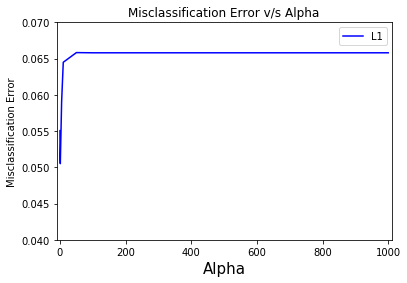

In [65]:
plt.xlim(-10,1010)
plt.ylim(0.040,0.07)
print (MSE)
print (alpha_values)
plt.xlabel("Alpha",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s Alpha')
plt.plot(alpha_values,MSE,'b',label="L1")
plt.legend()
plt.show()

In [66]:
nb = MultinomialNB(alpha = optimal_alpha)

# fitting the model
nb.fit(reviews_train_bow , reviews_score_train)

# predict the response
pred = nb.predict(reviews_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the naive bayes for alpha = %f is %f%%' % (optimal_alpha, acc))


The accuracy of the naive bayes for alpha = 1.000000 is 92.720408%


In [13]:
# # Reference link
# # https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
# neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
# pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

# print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
# print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

In [67]:
log_prob_reviews = nb.feature_log_prob_
bow_features = count_vect.get_feature_names()
print (len(bow_features))
print (log_prob_reviews.shape)

26884
(2, 26884)


In [68]:
feature_prob = pd.DataFrame(log_prob_reviews, columns = bow_features)
feature_prob_transpose = feature_prob.T
print (feature_prob_transpose.shape)
# feature_prob_transpose.head()



(26884, 2)


### Feature-extraction :

In [69]:
print("\n\n  25 Positive Features:-\n",feature_prob_transpose[1].sort_values(ascending = False)[0:25])
print("\n\n 25 Negative Features:-\n",feature_prob_transpose[0].sort_values(ascending = False)[0:25])



  25 Positive Features:-
 like      -4.469416
tast      -4.514218
good      -4.647096
flavor    -4.673237
great     -4.691812
tea       -4.708345
love      -4.730319
use       -4.757726
one       -4.804626
product   -4.862906
tri       -4.929346
make      -5.020305
get       -5.144885
coffe     -5.200496
best      -5.383024
time      -5.397491
eat       -5.401703
food      -5.403675
buy       -5.424618
amazon    -5.425482
find      -5.440873
realli    -5.458291
would     -5.481488
also      -5.498859
dont      -5.572025
Name: 1, dtype: float64


 25 Negative Features:-
 tast      -4.328971
like      -4.408149
product   -4.476942
one       -4.803368
flavor    -4.898075
tri       -4.995936
would     -4.999313
good      -5.098180
use       -5.165752
tea       -5.192744
buy       -5.233937
order     -5.256280
get       -5.284367
coffe     -5.378629
food      -5.410431
dont      -5.422407
box       -5.429315
even      -5.499299
amazon    -5.511454
make      -5.549810
eat       -5.573550
m

In [70]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)

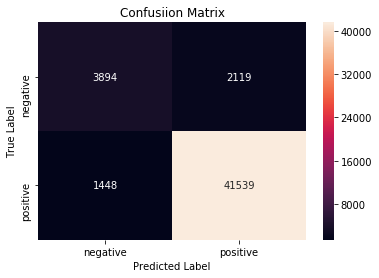

In [71]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [72]:

pred = nb.predict(reviews_test_bow)
acc = accuracy_score(reviews_score_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = 1 is %f%%' % (acc))


****Test accuracy for alpha = 1 is 91.213333%


In [73]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test, pred)

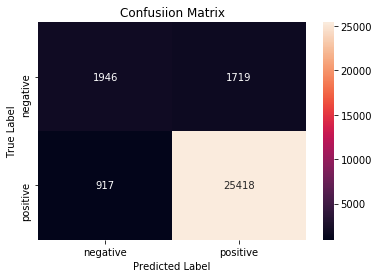

In [74]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [75]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
print ("confusion matrix ", conf_matrix)
print("Precision on test set: %0.3f"%(precision_score(reviews_score_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(reviews_score_test, pred)))
print("F1_score on test set: %0.3f"%(f1_score(reviews_score_test, pred)))
print (classification_report(reviews_score_test, pred))


confusion matrix  [[ 1946  1719]
 [  917 25418]]
Precision on test set: 0.937
Recall on test set: 0.965
F1_score on test set: 0.951
              precision    recall  f1-score   support

           0       0.68      0.53      0.60      3665
           1       0.94      0.97      0.95     26335

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.81      0.75      0.77     30000
weighted avg       0.91      0.91      0.91     30000



Taking reviews from zomato and testing if the models predicts correctly or not  :

In [76]:

# test_string = ['Never Ever Going To Order Food From Burger King Waste Of Money']
# test_string = ['goood service']
# test_string = [' Food was great.']
# test_string = ['Not criticising but i dont know whats too crazy about this place']
# test_string = ['A good place to go out with friends and have some amazing burgers, the staff is friendly and the service is quick.']
# test_string = ['The Whopper had some taste of Nacho chips and I loved them with the burger.']
test_string = ['stink']
# test_string = ["The most delicious grilled chicken with porcini mushroom sauce I've had!! This took my satisfaction upto the highest notches!"]

a = count_vect.transform(test_string)
print (nb.predict(a))

[1]


Observation:
- Model works well with unseen data . 
- Accuracy of 91% on unseen data . 
- Model is more baised towards positive points as we can conclude from confusion matrix . 

# TF-IDF :

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
reviews_train_tfidf = tf_idf_vect.fit_transform(reviews_train['CleanedText'].values)
reviews_cv_tfidf = tf_idf_vect.transform(reviews_cv['CleanedText'].values)
reviews_test_tfidf = tf_idf_vect.transform(reviews_test['CleanedText'].values)

In [77]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score

alpha_values = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]


# empty list that will hold cv scores
# cv_scores = []

# # perform 10-fold cross validation
# for alpha_value in alpha_values:
    
#     nb = MultinomialNB(alpha=alpha_value)
#     scores = cross_val_score(nb, reviews_train_tfidf, reviews_score_train, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())
#     print('\nCV accuracy for alpha = %f is %f%%' % (alpha_value, scores.mean()*100))
# print (cv_scores)
# # changing to misclassification error
# MSE = [1 - x for x in cv_scores]

# # determining best k
# optimal_alpha = alpha_values[MSE.index(min(MSE))]
# print('\nThe optimal alpha is %f.' % optimal_alpha)

# # plot misclassification error vs k 
# plt.plot(alpha_values, MSE)

# for xy in zip(alpha_values, np.round(MSE,3)):
#     plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

# plt.xlabel('Alpha value')
# plt.ylabel('Misclassification Error')
# plt.show()

# print("the misclassification error for each alpha value is : ", np.round(MSE,3))


cv_scores = []

for i in alpha_values:
    # instantiate learning model (k = 30)
    nb = MultinomialNB(alpha=i)

    # fitting the model on crossvalidation train
    nb.fit(reviews_train_tfidf, reviews_score_train)

    # predict the response on the crossvalidation train
    pred = nb.predict(reviews_cv_tfidf)

    # evaluate CV accuracy
    f1 = f1_score(reviews_score_cv, pred) 
    
    cv_scores.append(f1)
#     print('\nCV accuracy for k = %d is %d%%' % (i, acc))

MSE = [1 - x for x in cv_scores]
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal alpha is %f.' % optimal_alpha)



The optimal alpha is 0.010000.


[0.06580049229832263, 0.06580049229832263, 0.06580049229832263, 0.06580049229832263, 0.06580049229832263, 0.06580049229832263, 0.06580049229832263, 0.06580049229832263, 0.06295344041951989, 0.05757498077416057, 0.05206769835929825, 0.052884739713982665, 0.05575595176749448, 0.05693190296107642, 0.05831899540330243]
[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]


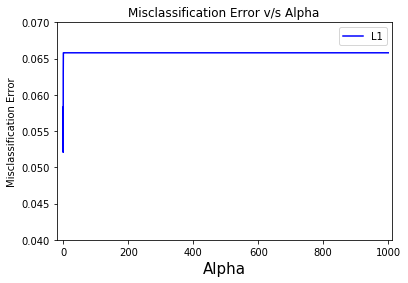

In [79]:
plt.xlim(-20,1010)
plt.ylim(0.040,0.07)
print (MSE)
print (alpha_values)
plt.xlabel("Alpha",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s Alpha')
plt.plot(alpha_values,MSE,'b',label="L1")
plt.legend()
plt.show()

In [80]:
nb = MultinomialNB(alpha = optimal_alpha)

# fitting the model
nb.fit(reviews_train_tfidf , reviews_score_train)

# predict the response
pred = nb.predict(reviews_train_tfidf)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the naive bayes for alpha = %f is %f%%' % (optimal_alpha, acc))


The accuracy of the naive bayes for alpha = 0.010000 is 99.924490%


In [81]:
log_prob_reviews = nb.feature_log_prob_
bow_features = tf_idf_vect.get_feature_names()
print (len(bow_features))
print (log_prob_reviews.shape)

727815
(2, 727815)


In [82]:
print("\n\n  25 Positive Features:-\n",feature_prob_transpose[1].sort_values(ascending = False)[0:25])
print("\n\n 25 Negative Features:-\n",feature_prob_transpose[0].sort_values(ascending = False)[0:25])



  25 Positive Features:-
 like      -4.469416
tast      -4.514218
good      -4.647096
flavor    -4.673237
great     -4.691812
tea       -4.708345
love      -4.730319
use       -4.757726
one       -4.804626
product   -4.862906
tri       -4.929346
make      -5.020305
get       -5.144885
coffe     -5.200496
best      -5.383024
time      -5.397491
eat       -5.401703
food      -5.403675
buy       -5.424618
amazon    -5.425482
find      -5.440873
realli    -5.458291
would     -5.481488
also      -5.498859
dont      -5.572025
Name: 1, dtype: float64


 25 Negative Features:-
 tast      -4.328971
like      -4.408149
product   -4.476942
one       -4.803368
flavor    -4.898075
tri       -4.995936
would     -4.999313
good      -5.098180
use       -5.165752
tea       -5.192744
buy       -5.233937
order     -5.256280
get       -5.284367
coffe     -5.378629
food      -5.410431
dont      -5.422407
box       -5.429315
even      -5.499299
amazon    -5.511454
make      -5.549810
eat       -5.573550
m

In [83]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)

[[ 5985    28]
 [    9 42978]]


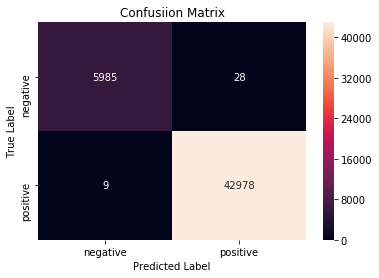

In [84]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [85]:
pred = nb.predict(reviews_test_tfidf)
acc = accuracy_score(reviews_score_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = 0.01 is %f%%' % (acc))


****Test accuracy for alpha = 0.01 is 90.460000%


In [86]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test, pred)
print (conf_matrix)

[[  967  2698]
 [  164 26171]]


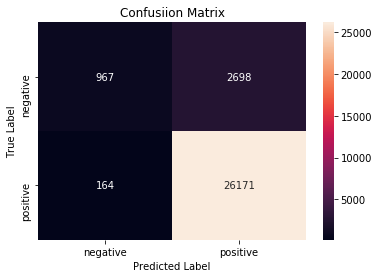

In [87]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [88]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
print ("confusion matrix ", conf_matrix)
print("Precision on test set: %0.3f"%(precision_score(reviews_score_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(reviews_score_test, pred)))
print("F1_score on test set: %0.3f"%(f1_score(reviews_score_test, pred)))
print (classification_report(reviews_score_test, pred))

confusion matrix  [[  967  2698]
 [  164 26171]]
Precision on test set: 0.907
Recall on test set: 0.994
F1_score on test set: 0.948
              precision    recall  f1-score   support

           0       0.85      0.26      0.40      3665
           1       0.91      0.99      0.95     26335

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.88      0.63      0.68     30000
weighted avg       0.90      0.90      0.88     30000



Observation :

- Model is more baised towards positive points as we can conclude from confusion matrix . 
- Accuracy of 90% on unseen dataset . 

Conclusion :
 - Need more data with negative points so that model can be trained properly . 
 - We can use Naive Bayes for text classification like spam filtering etc .
 - Tf-idf classifies better than BoW . 
 - We can't apply Naive Bayes on W2V as it trys to find relationship of the features . And NB can be applied on independent features .

In [89]:
models = pd.DataFrame({'Model': ['Naive Bayes with Bow', "Naive Bayes with TFIDF"], 'Alpha': [1, 0.01], 'Train Error': [0.0728,0.0008], 'Test Error': [0.087, 0.0954], 'Accuracy': [91.2, 90.4]}, columns = ["Model", "Alpha", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Alpha,Train Error,Test Error,Accuracy
0,Naive Bayes with Bow,1.00,0.0728,0.0870,91.2
1,Naive Bayes with TFIDF,0.01,0.0008,0.0954,90.4
